In [36]:
%matplotlib inline
import pandas
import matplotlib.pyplot as plt 

Here, we will look at various ways to classify the proteins in our data set.

In [37]:
df = pandas.read_csv( '../data_sets/experimental/thermo_paper_data_set.csv', index_col=0 )

The most obvious is by expression. 

In [38]:
df.expression.value_counts()

1    92
0    37
Name: expression, dtype: int64

What are some other ways to split up the proteins into two classes? 

### Bad mutations versus neutral and good mutations

The first class contains proteins that do not expresss and proteins that have a Tm of less than 39 C. The second class is all the rest of the proteins. 

In [39]:
my_clf = []

for idx, row in df.iterrows():
    if row.expression == 0 or row.tm < 39.2:
        my_clf.append( 0 ) 
    else:
        my_clf.append( 1 ) 
        
df[ 'my_clf' ] = my_clf 
df.my_clf.value_counts()

1    66
0    63
Name: my_clf, dtype: int64

In [40]:
f = pandas.read_csv( 'feature_sets/expression_combined.csv', index_col=0 ).drop( 'expression', axis=1 ) 

software = []

for col in f.columns:
    if '_enzyme_design' in col:
        software.append( 'enzyme_design' ) 
    elif '_foldx' in col:
        software.append( 'foldx' )
    elif '_ddg' in col:
        software.append( 'ddg' ) 

In [41]:
J = df[ [ 'my_clf' ] ].join( f ).dropna()
J.shape

(126, 77)

In [42]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cross_validation import StratifiedKFold, cross_val_predict
from sklearn.svm import SVC 
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import matthews_corrcoef, make_scorer, classification_report, roc_curve
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

In [43]:
scl = StandardScaler()
matt_score = make_scorer( matthews_corrcoef ) 

In [44]:
X = scl.fit_transform( J.ix[ : , 1: ] )
y = J.ix[ : , 0 ].as_matrix().ravel()

print X.shape
print y.shape 

(126, 76)
(126,)


Now we're attacking a problem with balanced classes.

In [45]:
roc_curve?

In [46]:
param_grid = [
    { 
        'svm__kernel': [ 'linear', 'rbf', 'poly' ], 
        'svm__C': [ 3e-2, 3e-1, 3, 3e1 ], 
        'kbest__k': [ 2, 10, 50 ], 
    }
]

/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [22] are constant.
  UserWarning)
/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [22 56] are constant.
  UserWarning)


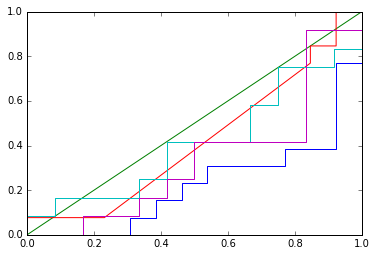

In [47]:
plt.figure()
skf = StratifiedKFold( y, n_folds=5, shuffle=True ) 
for train, test in skf:
        
    pln = Pipeline([('kbest',SelectKBest()), ('svm',SVC(probability=True))])
    clf = GridSearchCV( pln, param_grid, scoring=matt_score )
    preds = clf.fit( X[ train, : ], y[ train ] ).predict( X[ test, : ] ) 
    probs = clf.fit( X[ train, : ], y[ train ] ).predict_proba( X[ test, : ] )[ : , 0 ]
    tpr, fpr, __ = roc_curve( y[ test ], probs ) 
    plt.plot( tpr, fpr ) 
    #print classification_report( y[ test ], preds ) 